In [223]:
import numpy as np
import matplotlib.pyplot as plt

In [226]:
data = np.load('Subchannel/results/test_results.npz')

# branch inputs
input0 = data['branch1']
input1 = data['branch2'][:, 0]
input2 = data['branch2'][:, 1]

# predictions
pred = data['predictions']
# ground truth
gt = data['targets']

# print shapes
print(f'input0 shape: {input0.shape}')
print(f'input1 shape: {input1.shape}')
print(f'input2 shape: {input2.shape}')
print(f'pred shape: {pred.shape}')
print(f'gt shape: {gt.shape}')


# load mesh points
mesh_points = np.load('Subchannel/data/share/trunk_input.npz')['trunk']
x = mesh_points[:, 0]
y = mesh_points[:, 1]

input0 shape: (1000, 100)
input1 shape: (1000,)
input2 shape: (1000,)
pred shape: (1000, 1733, 3)
gt shape: (1000, 1733, 3)


In [228]:
# compute relative l2 error for each channel [# samples, # mesh points, # channels]
def rel_l2_error(pred, gt):
    # compute relative l2 error
    err = np.linalg.norm(pred - gt, axis=-1) / np.linalg.norm(gt, axis=-1)
    return err
# compute relative l2 error for each channel
err0 = rel_l2_error(pred[:, :, 0], gt[:, :, 0])
err1 = rel_l2_error(pred[:, :, 1], gt[:, :, 1])
err2 = rel_l2_error(pred[:, :, 2], gt[:, :, 2])

# compute mean relative l2 error for each channel
mean_err0 = np.mean(err0, axis=0)
mean_err1 = np.mean(err1, axis=0)
mean_err2 = np.mean(err2, axis=0)

# compute mean relative l2 error for each channel
mean_err0 = np.mean(mean_err0) * 100
mean_err1 = np.mean(mean_err1) * 100
mean_err2 = np.mean(mean_err2) * 100


# compute standard deviation of relative l2 error for each channel
std_err0 = np.std(err0, axis=0) * 100
std_err1 = np.std(err1, axis=0) * 100
std_err2 = np.std(err2, axis=0) * 100

# print mean and std of relative l2 error for each channel
print(f'Mean relative L2 error for channel 0: {mean_err0:.4f} +/- {std_err0:.4f}')
print(f'Mean relative L2 error for channel 1: {mean_err1:.4f} +/- {std_err1:.4f}')
print(f'Mean relative L2 error for channel 2: {mean_err2:.4f} +/- {std_err2:.4f}')

Mean relative L2 error for channel 0: 2.2111 +/- 0.0230
Mean relative L2 error for channel 1: 0.2682 +/- 0.1165
Mean relative L2 error for channel 2: 4.1496 +/- 0.0377


In [240]:
import pandas as pd

df = pd.DataFrame()

df['ch0'] = err0 * 100
df['ch1'] = err1 * 100
df['ch2'] = err2 * 100

# compute the mean over all channel per sample
df['mean'] = df.mean(axis=1)

# get the idx of the maximum mean and minimum mean also 50th percentile
df['50th_percentile'] = df['mean'].quantile(0.5)
# find the idx for 50th percentile
percentile_idx = df['mean'].sub(df['50th_percentile']).abs().idxmin()
print(f"Sample with 50th percentile mean relative error: {percentile_idx}, Mean: {df['mean'][percentile_idx]}")

print(df.iloc[percentile_idx])

Sample with 50th percentile mean relative error: 383, Mean: 2.201204538345337
ch0                2.206385
ch1                0.272172
ch2                4.125057
mean               2.201205
50th_percentile    2.201251
Name: 383, dtype: float64


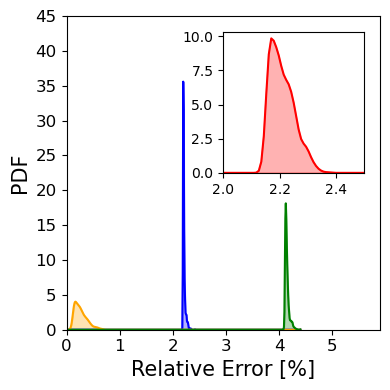

In [290]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, axs = plt.subplots(1, 1, figsize=(4, 4))

v_vals = err0 * 100
t_vals = err1 * 100
k_vals = err2 * 100
mean_vals = df['mean']

v_kde = gaussian_kde(v_vals)
t_kde = gaussian_kde(t_vals)
k_kde = gaussian_kde(k_vals)
mean_kde = gaussian_kde(mean_vals)

x_eval = np.linspace(0, max(v_vals.max(), t_vals.max(), k_vals.max(), mean_vals.max()), 500)
v_pdf = v_kde(x_eval)
t_pdf = t_kde(x_eval)
k_pdf = k_kde(x_eval)
mean_pdf = mean_kde(x_eval)

axs.plot(x_eval, v_pdf, color='blue')
axs.fill_between(x_eval, v_pdf, alpha=0.3, color='blue')


axs.plot(x_eval, t_pdf, color='orange')
axs.fill_between(x_eval, t_pdf, alpha=0.3, color='orange')


axs.plot(x_eval, k_pdf, color='green')
axs.fill_between(x_eval, k_pdf, alpha=0.3, color='green')

#
inset = axs.inset_axes([0.5, 0.5, 0.45, 0.45])  # Adjust as needed (x0, y0, w, h)

inset.plot(x_eval, mean_pdf, color='red')
inset.fill_between(x_eval, mean_pdf, alpha=0.3, color='red')
inset.set_xlim(2, 2.5)  # Zoomed-in x-range for mean
inset.set_ylim(0, max(mean_pdf) * 1.05)

axs.set_xlabel('Relative Error [%]', fontsize=15)
axs.set_ylabel('PDF', fontsize=15)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.set_xlim(0, x_eval.max()+1.5)
axs.set_ylim(0, 45.0)

plt.tight_layout()
plt.savefig('Subchannel/analysis/subchannel_pdf.png', dpi=300)
plt.show()

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.patches as patches

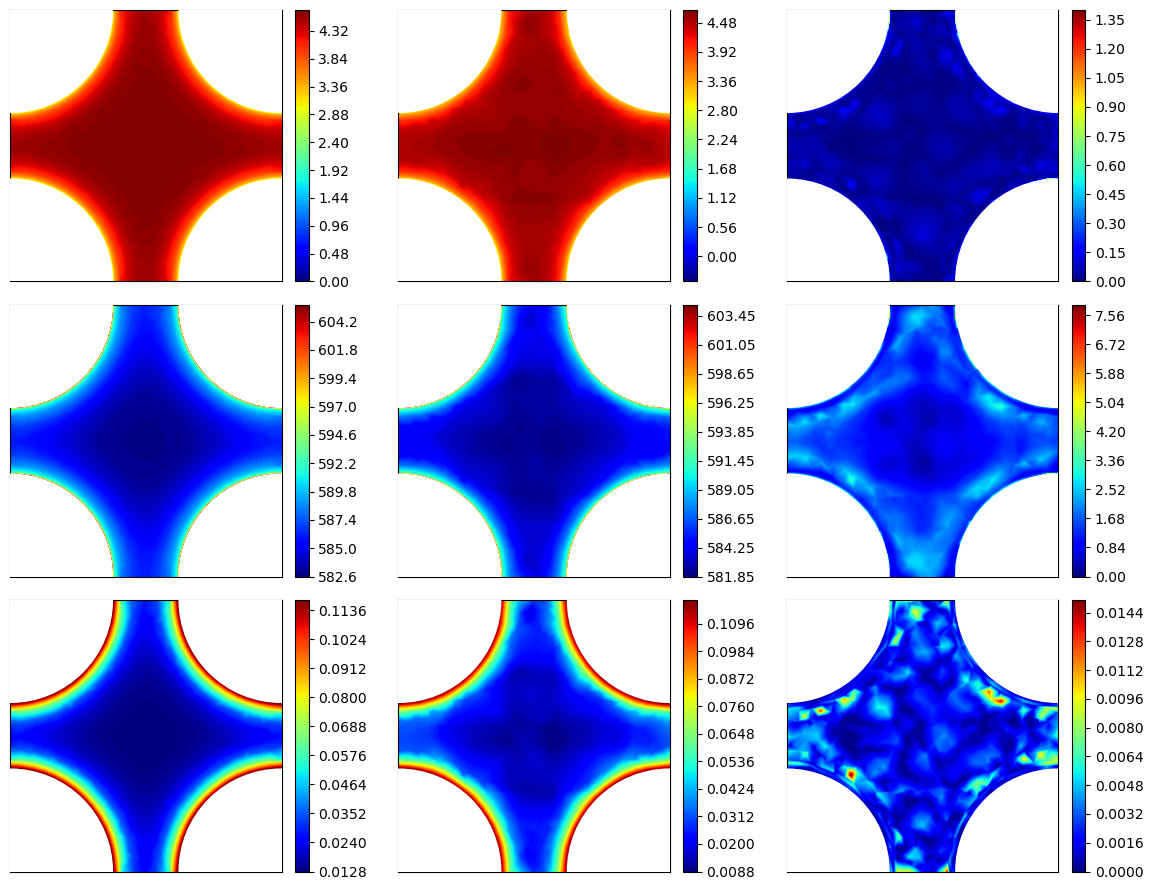

In [303]:
# Triangulation
tri = mtri.Triangulation(x, y)

# Set up figure
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

# Geometry parameters
pitch = 12.6e-3
radius = 9.5e-3 / 2
circle_centers = [
    (-pitch/2, pitch/2),
    (pitch/2, pitch/2),
    (-pitch/2, -pitch/2),
    (pitch/2, -pitch/2)
]

full_extent = 0.0063

# ground truth ch 0
cf_full = ax[0, 0].tricontourf(tri, gt[percentile_idx, :, 0], levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[0, 0], fraction=0.046, pad=0.04)

ax[0, 0].set_xlim(-full_extent, full_extent)
ax[0, 0].set_ylim(-full_extent, full_extent)
ax[0, 0].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[0, 0].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# prediction ch 0
cf_full = ax[0, 1].tricontourf(tri, pred[percentile_idx, :, 0], levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[0, 1], fraction=0.046, pad=0.04)
ax[0, 1].set_xlim(-full_extent, full_extent)
ax[0, 1].set_ylim(-full_extent, full_extent)
ax[0, 1].set_aspect('equal')

# Add white circles
for xc, yc in circle_centers:
    ax[0, 1].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# absolute error ch 0
abs_err0 = np.abs(pred[percentile_idx, :, 0] - gt[percentile_idx, :, 0])
cf_full = ax[0, 2].tricontourf(tri, abs_err0, levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[0, 2], fraction=0.046, pad=0.04)
ax[0, 2].set_xlim(-full_extent, full_extent)
ax[0, 2].set_ylim(-full_extent, full_extent)
ax[0, 2].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[0, 2].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
    
# ground truth ch 1
cf_full = ax[1, 0].tricontourf(tri, gt[percentile_idx, :, 1], levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[1, 0], fraction=0.046, pad=0.04)
ax[1, 0].set_xlim(-full_extent, full_extent)
ax[1, 0].set_ylim(-full_extent, full_extent)
ax[1, 0].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[1, 0].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# prediction ch 1
cf_full = ax[1, 1].tricontourf(tri, pred[percentile_idx, :, 1], levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[1, 1], fraction=0.046, pad=0.04)
ax[1, 1].set_xlim(-full_extent, full_extent)
ax[1, 1].set_ylim(-full_extent, full_extent)
ax[1, 1].set_aspect('equal')   
# Add white circles
for xc, yc in circle_centers:
    ax[1, 1].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# absolute error ch 1
abs_err1 = np.abs(pred[percentile_idx, :, 1] - gt[percentile_idx, :, 1])
cf_full = ax[1, 2].tricontourf(tri, abs_err1, levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[1, 2], fraction=0.046, pad=0.04)
ax[1, 2].set_xlim(-full_extent, full_extent)
ax[1, 2].set_ylim(-full_extent, full_extent)
ax[1, 2].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[1, 2].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# ground truth ch 2
cf_full = ax[2, 0].tricontourf(tri, gt[percentile_idx, :, 2], levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[2, 0], fraction=0.046, pad=0.04)
ax[2, 0].set_xlim(-full_extent, full_extent)
ax[2, 0].set_ylim(-full_extent, full_extent)
ax[2, 0].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[2, 0].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# prediction ch 2
cf_full = ax[2, 1].tricontourf(tri, pred[percentile_idx, :, 2], levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[2, 1], fraction=0.046, pad=0.04)
ax[2, 1].set_xlim(-full_extent, full_extent)
ax[2, 1].set_ylim(-full_extent, full_extent)
ax[2, 1].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[2, 1].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))
    
# absolute error ch 2
abs_err2 = np.abs(pred[percentile_idx, :, 2] - gt[percentile_idx, :, 2])
cf_full = ax[2, 2].tricontourf(tri, abs_err2, levels=150, cmap='jet')
cbar_full = fig.colorbar(cf_full, ax=ax[2, 2], fraction=0.046, pad=0.04)
ax[2, 2].set_xlim(-full_extent, full_extent)
ax[2, 2].set_ylim(-full_extent, full_extent)
ax[2, 2].set_aspect('equal')
# Add white circles
for xc, yc in circle_centers:
    ax[2, 2].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))


# for all figures, no ticks
for i in range(3):
    for j in range(3):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()
plt.savefig('Subchannel/analysis/subchannel_50th_percentile.png', dpi=300)
plt.show()

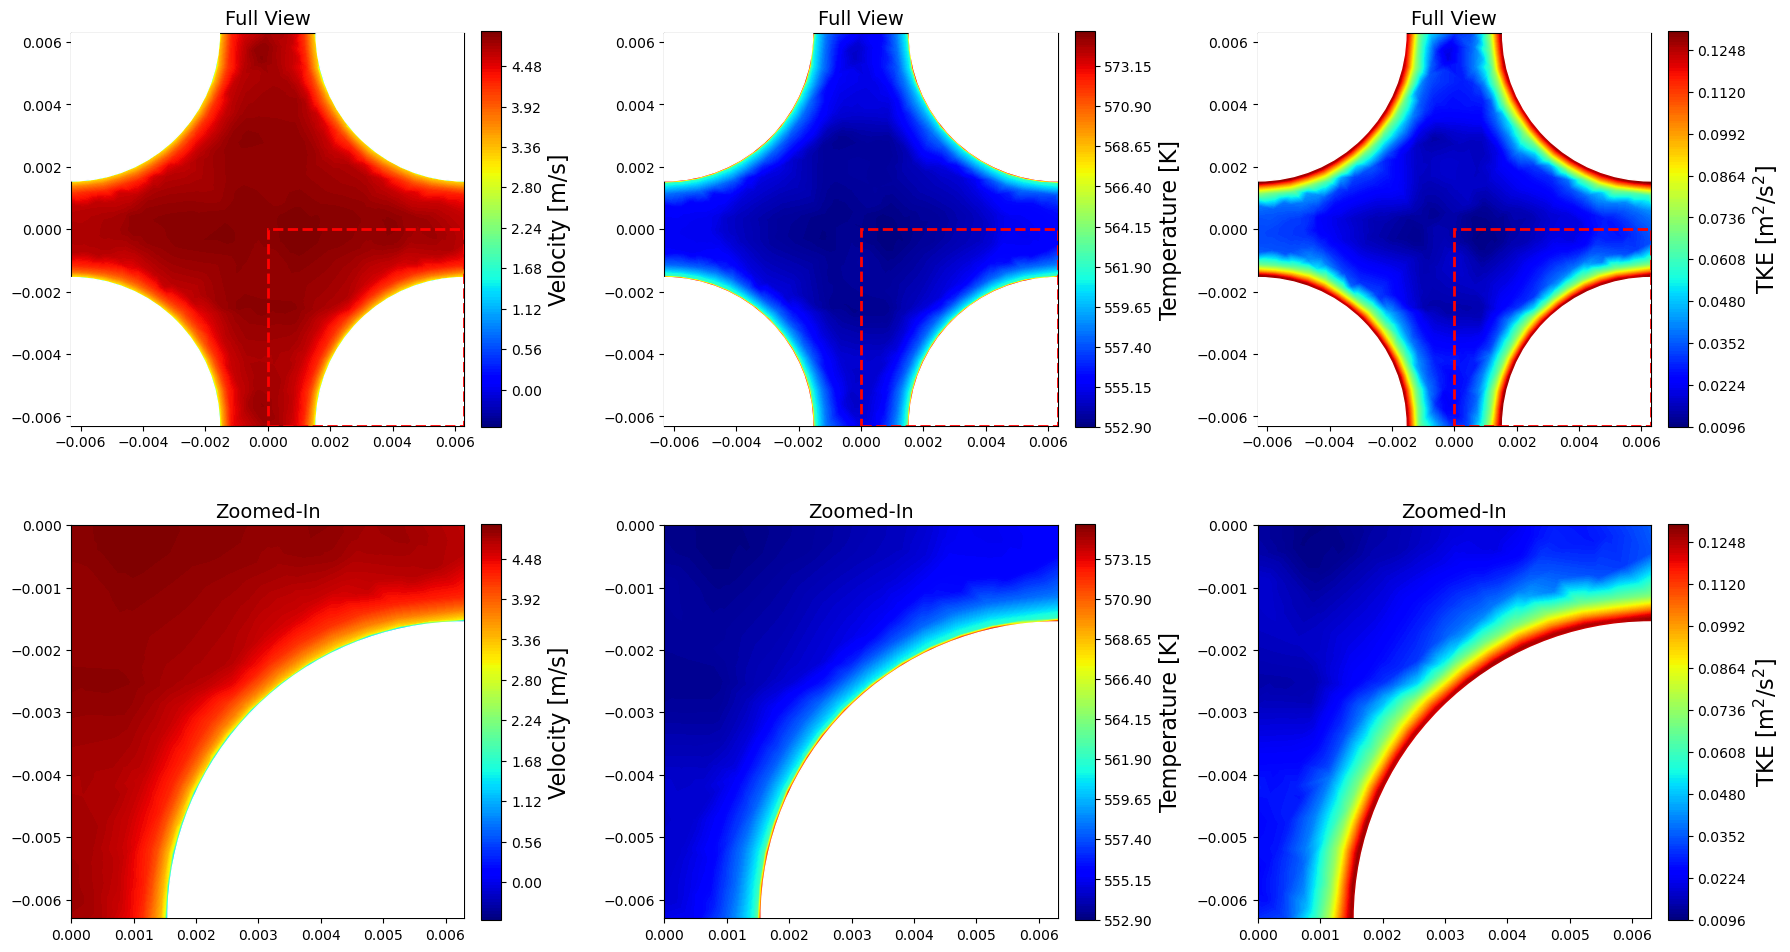

In [231]:
# Triangulation
tri = mtri.Triangulation(x, y)

# Set up figure
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

# Geometry parameters
pitch = 12.6e-3
radius = 9.5e-3 / 2
circle_centers = [
    (-pitch/2, pitch/2),
    (pitch/2, pitch/2),
    (-pitch/2, -pitch/2),
    (pitch/2, -pitch/2)
]

full_extent = 0.0063
x_min_zoom, x_max_zoom = 0, 0.0063
y_min_zoom, y_max_zoom = -0.0063, 0

# Channel names
channel_name = ['Velocity [m/s]', 'Temperature [K]', r'TKE $\rm [m^2/s^2]$']

# Store contour handles
contour_full = []
contour_zoom = []
cbars_full = []
cbars_zoom = []

# --- Initialization ---
for i in range(3):
    # Top row: full view
    cf_full = ax[0, i].tricontourf(tri, pred[0, :, i], levels=150, cmap='jet')
    contour_full.append(cf_full)
    cbar_full = fig.colorbar(cf_full, ax=ax[0, i], fraction=0.046, pad=0.04)
    cbar_full.set_label(channel_name[i], fontsize=16)
    cbars_full.append(cbar_full)

    ax[0, i].set_xlim(-full_extent, full_extent)
    ax[0, i].set_ylim(-full_extent, full_extent)
    ax[0, i].set_title('Full View', fontsize=14)
    ax[0, i].set_aspect('equal')

    # Add white circles
    for xc, yc in circle_centers:
        ax[0, i].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))

    # Add zoom rectangle
    zoom_rect = patches.Rectangle(
        (x_min_zoom, y_min_zoom),
        x_max_zoom - x_min_zoom,
        y_max_zoom - y_min_zoom,
        linewidth=2,
        edgecolor='red',
        linestyle='--',
        facecolor='none',
        zorder=6
    )
    ax[0, i].add_patch(zoom_rect)

    # Bottom row: zoomed-in view
    cf_zoom = ax[1, i].tricontourf(tri, pred[0, :, i], levels=150, cmap='jet')
    contour_zoom.append(cf_zoom)
    cbar_zoom = fig.colorbar(cf_zoom, ax=ax[1, i], fraction=0.046, pad=0.04)
    cbar_zoom.set_label(channel_name[i], fontsize=16)
    cbars_zoom.append(cbar_zoom)

    ax[1, i].set_xlim(x_min_zoom, x_max_zoom)
    ax[1, i].set_ylim(y_min_zoom, y_max_zoom)
    ax[1, i].set_title('Zoomed-In', fontsize=14)
    ax[1, i].set_aspect('equal')

    for xc, yc in circle_centers:
        ax[1, i].add_patch(plt.Circle((xc, yc), radius, color='white', zorder=5))

plt.tight_layout()
plt.savefig('Subchannel/analysis/test.png', dpi=300)
plt.show()